# **Тематическое моделирование и генерация текста при помощи GPT-2**

Данная лабораторная будет состоять из двух частей: анализ скрытых тем в постах (topic modeling) и генерация постов при помощи дообучения (fine-tuning) модели gpt-2. 

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

/usr/local/lib/python3.9/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/gpreda/covid19-tweets")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/kaggle/api_client.py:181: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  response_data.getheaders())


100%|██████████| 27.9M/27.9M [00:00<00:00, 95.7MB/s]


## **Topic Modeling** 



### **Задание 1**

Загрузите набор данных, который содержит тексты постов про covid19
([COVID19 Tweets](https://www.kaggle.com/datasets/gpreda/covid19-tweets))

In [ ]:
df = pd.read_csv('./covid19-tweets/covid19_tweets.csv')
df = df[["text"]]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Задание 2**

Из исходного датасета оставьте только колонку ‘text’  и подготовьте данные для дальнейшей работы, выполнив этапы предобработки из предыдущей лабораторной работы (нижний регистр, удаление стоп-слов и пунктуации, токенизация, лемматизация)

In [ ]:
# Переводим текст в нижний регистр
df["text"] = df["text"].str.lower()

# Удаляем пунктуацию и цифры
df["text"] = df["text"].str.translate(str.maketrans('', '', string.punctuation + string.digits))

# Токенизируем текст
df["text"] = df["text"].apply(word_tokenize)

# Удаляем стоп-слова
stop_words = stopwords.words('english')
df["text"] = df["text"].apply(lambda x: [word for word in x if word not in stop_words])

# Лемматизируем текст
lemmatizer = WordNetLemmatizer()
df["text"] = df["text"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [ ]:
df.head()

,text
0,"[smelled, scent, hand, sanitizers, today, some..."
1,"[hey, yankee, yankeespr, mlb, wouldnt, made, s..."
2,"[diane, wdunlap, realdonaldtrump, trump, never..."
3,"[brookbanktv, one, gift, covid, give, apprecia..."
4,"[july, medium, bulletin, novel, coronavirusupd..."


### **Задание 3**

На основе получившихся данных после предобработки создайте словарь слов и корпус частот их встречаймости с помощью библиотеки *gensim*

In [ ]:
# Создаем словарь слов
dictionary = Dictionary(df["text"])

# Создаем корпус частот встречаемости
corpus = [dictionary.doc2bow(text) for text in df["text"]]

# Применяем TF-IDF модель к корпусу
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
print(dictionary)

Dictionary<327539 unique tokens: ['hand', 'httpstcoqzvybrogb', 'intoxicated', 'past', 'sanitizers']...>


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Задание 4**

Постройте и обучите модель LDA, передав входные параметры. Определите наиболее оптимальное количество скрытых тем.

In [ ]:
# Функция для определения оптимального количества тем
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values

Optimal number of topics: 6


In [ ]:
# Вычисляем coherence score для разного количества тем
coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=df["text"], start=2, limit=20, step=1)

In [ ]:
# Находим оптимальное количество тем
optimal_num_topics = coherence_values.index(max(coherence_values)) + 2
print(f"Optimal number of topics: {optimal_num_topics}")

In [ ]:
# Обучаем модель LDA с оптимальным количеством тем
lda_model = LdaModel(corpus=corpus_tfidf, num_topics=optimal_num_topics, id2word=dictionary)

# Выводим топ-слова для каждой темы
for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print('\n')

Topic: 0 
Words: 0.006*"’" + 0.006*"covid" + 0.004*"mask" + 0.004*"people" + 0.003*"realdonaldtrump" + 0.003*"trump" + 0.003*"amp" + 0.003*"get" + 0.003*"pandemic" + 0.003*"coronavirus"


Topic: 1 
Words: 0.019*"case" + 0.012*"new" + 0.011*"death" + 0.009*"total" + 0.007*"coronavirus" + 0.007*"india" + 0.006*"covid" + 0.005*"confirmed" + 0.005*"update" + 0.005*"august"


Topic: 2 
Words: 0.004*"aug" + 0.002*"berlin" + 0.002*"status" + 0.002*"power" + 0.001*"rally" + 0.001*"enough" + 0.001*"germany" + 0.001*"known" + 0.001*"technology" + 0.001*"watching"


Topic: 3 
Words: 0.005*"covid" + 0.004*"’" + 0.004*"pandemic" + 0.003*"amp" + 0.003*"student" + 0.003*"still" + 0.002*"people" + 0.002*"coronavirus" + 0.002*"u" + 0.002*"school"


Topic: 4 
Words: 0.004*"cross" + 0.003*"joebiden" + 0.003*"mark" + 0.002*"democrat" + 0.002*"alabama" + 0.002*"potus" + 0.002*"fresh" + 0.002*"maga" + 0.002*"biden" + 0.002*"bc"


Topic: 5 
Words: 0.003*"bringing" + 0.003*"blood" + 0.003*"recorded" + 0.002*"

Тема 0 может быть связана с вопросами о масках, Трампе и пандемии, тема 1 - с обновлениями статистики по заболевшим и умершим в связи с COVID-19 в Индии и в мире, тема 2 - с событиями в Берлине и с технологиями, тема 3 - с образованием и пандемией, тема 4 - с выборами и политическими партиями, а тема 5 - с донорством плазмы и другими темами.

### **Задание 5**
Визуализируйте результаты.

In [ ]:
# Визуализируем модель LDA
vis = gensimvis.prepare(lda_model, corpus_tfidf, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Полученные результаты модели LDA свидетельствуют о том, что тексты связанные с COVID-19 можно разделить на несколько тем. Некоторые темы имеют общие ключевые слова и могут пересекаться, в то время как другие темы уникальны и имеют мало общего с другими темами.

# Генерация текста. GPT-2

## Задание 1
Загрузите тот же самый датасет из части 1 (topic modeling)

In [ ]:
df = pd.read_csv('./covid19-tweets/covid19_tweets.csv')
df = df[["text"]]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Задание 2
Приведите тексты к нижнему регистру, удалите пунктуацию и остальные символы

In [ ]:
!pip install emoji

In [ ]:
import re
import emoji

#remove @username from tweet
def remove_username(tweet):
    return re.sub('@[^\s]+','',tweet)

#remove #hashtags from tweet
def remove_hashtag(tweet):
    return re.sub('#[^\s]+','',tweet)

#remove emojis from tweet
def remove_emoji(tweet):
    return emoji.replace_emoji(tweet, replace='')

#remove https from tweet
def remove_https(tweet):
    return re.sub('https[^\s]+','',tweet)

#remove youtube from tweet
def remove_youtube(tweet):
    return re.sub('m.youtube[^\s]+','',tweet)

#remove &amp; from tweet
def remove_amp(tweet):
    return re.sub('&amp;','',tweet)

#remove twitter.com links from tweet
def remove_twitter(tweet):
    return re.sub('[^\s]+.com[^\s]+','',tweet)

#remove space from tweet
def remove_space(tweet):
    return re.sub(' +', ' ', tweet)


df['text'] = df['text'].apply(remove_username) #removing usernames
df['text'] = df['text'].apply(remove_hashtag) #removing hashtags
df['text'] = df['text'].apply(remove_emoji) #removing emojis
df['text'] = df['text'].apply(remove_https) #removing https
df['text'] = df['text'].apply(remove_youtube) #removing youtube
df['text'] = df['text'].apply(remove_amp) #removing amp
df['text'] = df['text'].apply(remove_twitter) #removing twitter.com links
df['text'] = df['text'].apply(remove_space) #removing space
df['text'] = df['text'].replace(' ', np.nan) #replacing ' ' with np.nan
df['text'] = df['text'].replace('', np.nan) #replacing '' with np.nan

# Переводим текст в нижний регистр
df["text"] = df["text"].str.lower()
# Удаляем пунктуацию и цифры
df["text"] = df["text"].str.translate(str.maketrans('', '', string.punctuation + string.digits))
df = df.dropna(axis=0, subset=['text']) #dropping rows if any of the renderedContent has nan values
df = df.reset_index(drop=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:6: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \s
<>:18: DeprecationWarning: invalid escape sequence \s
<>:22: DeprecationWarning: invalid escape sequence \s
<>:30: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \s
<>:18: DeprecationWarning: invalid escape sequence \s
<>:22: DeprecationWarning: invalid escape sequence \s
<>:30: DeprecationWarning: invalid escape sequence \s
<ipython-input-29-c7215b8ab5a9>:6: DeprecationWarning: invalid escape sequence \s
  return re.sub('@[^\s]+',

## Задание 3 
Из исходного количества данных сделайте случайную подвыборку (или не случайную, используя какие-либо эвристики) размером в 5.000 объектов. Мало, зато хватает ОЗУ коллаба, чтобы не вылететь. Если Ваши ресурсы Вам позволяют, то берите подвыборку большим размером. 

In [ ]:
df = df.sample(5000)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(df.shape)
df

(5000, 1)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
134848,\n\ncover your cough and clean your hands\n\n...
175013,\n\n \n\nright out of the devils mouth \n\n\n...
93960,deflection from the real shitshows which are ...
94882,reports new positive cases in last hours to...
124682,vaccination coverage in countries is better th...
...,...
65072,dr deborah birx coordinator of the white house...
128392,tests in in last hours \n\nrtpcr \nantigen \...
125490,maxicare hosts day free testing for over k mem...
175816,any plan to bring kids into a few buildings is...


## Задание 4
Загрузите предобученную модель GPT-2 и дообучите на наших данных. 

In [ ]:
corpus = [tweet for tweet in df['text']]
len(corpus)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5000

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Frequency')

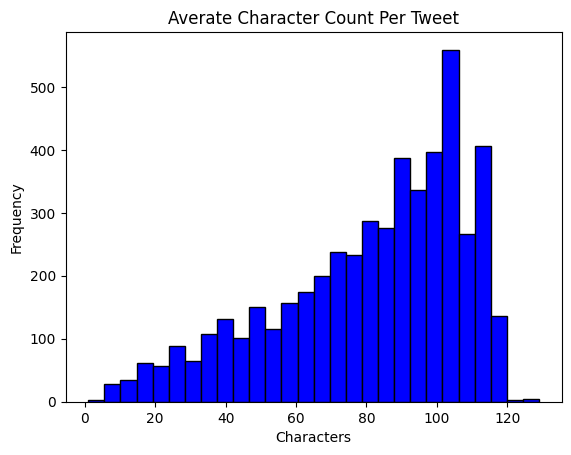

In [ ]:
#understanding general trend in total character count per tweet
word_count = [len(tweet) for tweet in corpus]

# matplotlib histogram
plt.hist(word_count, color = 'blue', edgecolor = 'black',
         bins = int(280/10))

# Add labels
plt.title('Averate Character Count Per Tweet')
plt.xlabel('Characters')
plt.ylabel('Frequency')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Text(0, 0.5, 'Frequency')

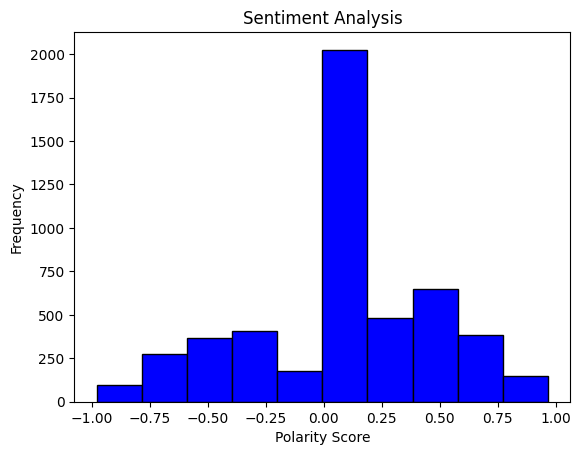

In [ ]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
sentiment = [sid.polarity_scores(tweet)['compound'] for tweet in corpus]

# matplotlib histogram
plt.hist(sentiment, color = 'blue', edgecolor = 'black')
# Add labels
plt.title('Sentiment Analysis')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')

In [ ]:
!pip install gpt_2_simple

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gpt_2_simple: filename=gpt_2_simple-0.8.1-py3-none-any.whl size=24576 sha256=03f5aef2cca715a4716f424498151ea767eac54b2afa98382f6b9e6669266f3c
  Stored in directory: /root/.cache/pip/wheels/4e/28/f0/2f12e470be10d6804b193e4193d274c88995010fae512a67cf
Successfully built gpt_2_simple


In [ ]:
import gpt_2_simple as gpt2

#downloading the gpt-2 model that was trained using 124 million parameters
gpt2.download_gpt2(model_name="124M")

#saving the corpus as text file
file = open('tweet.txt', 'w')
file.write('\n'.join(corpus))
file.close()

#starting the gpt2 tensorflow session
sess = gpt2.start_tf_sess()

#finetuning
gpt2.finetune(sess,
              dataset='tweet.txt',
              model_name='124M',
              steps=1000,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=500,
              save_every=100
              )

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Fetching checkpoint: 1.05Mit [00:00, 332Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 2.87Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 469Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:13, 38.1Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 344Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 4.36Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 5.18Mit/s]


Loading checkpoint models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


dataset has 101681 tokens
Training...
[10 | 25.82] loss=4.56 avg=4.56
[20 | 48.12] loss=4.23 avg=4.40
[30 | 70.72] loss=4.26 avg=4.35
[40 | 92.93] loss=4.01 avg=4.27
[50 | 115.03] loss=3.87 avg=4.18
[60 | 137.34] loss=3.92 avg=4.14
[70 | 159.70] loss=3.64 avg=4.07
[80 | 181.95] loss=3.57 avg=4.00
[90 | 204.20] loss=3.48 avg=3.94
[100 | 226.48] loss=3.24 avg=3.87
Saving checkpoint/run1/model-100
[110 | 251.78] loss=3.17 avg=3.80
[120 | 274.15] loss=2.73 avg=3.71
[130 | 296.47] loss=2.31 avg=3.59
[140 | 318.77] loss=2.82 avg=3.53
[150 | 341.06] loss=2.53 avg=3.46
[160 | 363.34] loss=2.15 avg=3.37
[170 | 385.64] loss=1.77 avg=3.27
[180 | 407.97] loss=2.56 avg=3.23
[190 | 430.30] loss=1.73 avg=3.14
[200 | 452.62] loss=1.68 avg=3.06
Saving checkpoint/run1/model-200


Instructions for updating:
Use standard file APIs to delete files with this prefix.


[210 | 477.64] loss=1.49 avg=2.98
[220 | 500.02] loss=1.33 avg=2.90
[230 | 522.38] loss=1.48 avg=2.83
[240 | 544.74] loss=1.34 avg=2.76
[250 | 567.11] loss=1.13 avg=2.69
[260 | 589.45] loss=0.80 avg=2.60
[270 | 611.72] loss=0.94 avg=2.53
[280 | 634.02] loss=0.64 avg=2.46
[290 | 656.41] loss=0.80 avg=2.39
[300 | 679.25] loss=0.59 avg=2.32
Saving checkpoint/run1/model-300
[310 | 705.71] loss=0.69 avg=2.26
[320 | 728.13] loss=0.63 avg=2.20
[330 | 750.45] loss=0.45 avg=2.14
[340 | 772.78] loss=0.38 avg=2.08
[350 | 795.13] loss=0.36 avg=2.02
[360 | 817.41] loss=0.37 avg=1.97
[370 | 839.72] loss=0.22 avg=1.91
[380 | 861.99] loss=0.26 avg=1.86
[390 | 884.28] loss=0.32 avg=1.81
[400 | 906.56] loss=0.24 avg=1.76
Saving checkpoint/run1/model-400
[410 | 931.42] loss=0.20 avg=1.72
[420 | 953.82] loss=0.13 avg=1.67
[430 | 976.16] loss=0.16 avg=1.63
[440 | 998.44] loss=0.10 avg=1.58
[450 | 1020.73] loss=0.14 avg=1.54
[460 | 1043.04] loss=0.09 avg=1.51
[470 | 1065.39] loss=0.09 avg=1.47
[480 | 1087.7

## Задание 5
После дообучения модели выведите примеры сгенерированных постов, которые начинались бы с “covid” или “covid19”

In [ ]:
gpt2_generated_tweet = gpt2.generate(sess,
              length=50,
              temperature=0.7,
              nsamples=10,
              batch_size=1,
              truncate = '<|endoftext|>',
              return_as_list=True,
              prefix='covid'
              )

for i, post in enumerate(gpt2_generated_tweet):
  print(i, post)
  print()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 covid data is trending and growing increasingly common these days 
help slow the spread of and identify at risk cases sooner by selfreporting your symptoms daily even if y… 
we’ve recently been reminded how grateful we are for healthcare workers volunteers around

1 covid historic spike in cases

 

 

their first doctor is a psychopathic and sundry… 
 deputy chief of staff to michael theocrat is a bad husband and father

and now he is a… 
ariz

2 covid

morning glory

then you should be doing your job

 
 my laymans measure of the r measure how many deaths daily in my laymans r is the highest i ever heard of… 
arizona is still very much

3 covid sarscov nviet v russia what for cash… 
 ‘looked after’ is ‘playing for time’ here’ telling the stories of grateful employees and… 
before the the song was that

4 covid  … 
finally the is back 



 
 new cases reported in today also  deaths reported  reported in  in dis… 
mmola there it is… 
 is global so this means there are a total of

5 c

In [ ]:
gpt2_generated_tweet = gpt2.generate(sess,
              length=50,
              temperature=0.7,
              nsamples=10,
              batch_size=1,
              truncate = '<|endoftext|>',
              return_as_list=True,
              )

for i, post in enumerate(gpt2_generated_tweet):
  print(i, post)
  print()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 the total number of samples tested up to th august is  including  samples tested yester… 
a m tested positive  samples tested dead last  samples in tow

me… 
 we know the pain of not being able to

1 oh i’m a 
always remember it’s a virus and don’t start a virus business by saying it has no deaths  always do your due diligence and see if there are any that may have infected  always inform

2 … 
i am now beginning to think that forbes is a tabloid magazine for financial matters it doesnt matter what is real… 
t

  deaths yesterday 

 too many positive cases

 too many test reports pending at testing centres

 s

3 “as leaders we often forget our own problems face… 
 leaders need to reflectively engage their respective audiences while remembering the impacted groups… 
as  really is messy it must be said that not only is the economy slowing but ho…

4 cohorted with lawyers to solicit donations of ₹… 
sarscov and the outside world will not survive on her monologue… 
we are extremely prou

In [ ]:
gpt2_generated_tweet = gpt2.generate(sess,
              length=50,
              temperature=0.7,
              nsamples=10,
              batch_size=1,
              truncate = '<|endoftext|>',
              return_as_list=True,
              prefix='covid',
              include_prefix=True
              )

for i, post in enumerate(gpt2_generated_tweet):
  print(i, post)
  print()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 covid in the us… 
as of thursday morning august th had more than  cases of the health ministry sai… 
highest singleday increase of  covid cases  deaths reported in india in the last  hours
 …

1 covid virus 
if you don’t believe me try again later meagan county’s covid effective th… 
so the parents of the little boy in the video are being punished like everyone else
for spreading lies the chinese

2 covid has no symptoms and you are almost sure cured  

just imagine being stuck with a government that doesn’t admit or apologize for the 
 
 industry body the food web lab tracks web traffic in substantia… 


3 covid and  pa… 
september  many wildoccult behaviors including drowning and car… 
 cases of and laboratory tests for potentially going into toxic waste water are locked down and taking… 
 is engulfing all of america under

4 covid wasn’t well received around the world and he tried to o… 
 has a fascinating side story that will hopefully lead them to heal better and find a loving h